# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import re
import time
from joblib import parallel_backend #to select the backend for the training
import pickle

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from skmultilearn.model_selection import IterativeStratification #can be removed latter
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
import xgboost as xgb


In [2]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')

with engine.connect() as connection:
    df = pd.read_sql('SELECT * FROM categories', connection) 

df.head(10)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,14,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,15,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
7,16,"Please, we need tents and water. We are in Sil...",Tanpri nou bezwen tant avek dlo nou zon silo m...,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,17,"I would like to receive the messages, thank you",Mwen ta renmen jouin messag yo. Merci,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,18,I am in Croix-des-Bouquets. We have health iss...,"Nou kwadebouke, nou gen pwoblem sant m yo nan ...",direct,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [7]:
#lets see if the data is imbalanced
df.drop(columns=['message', 'original', 'genre', 'id']).sum().sort_values(ascending=False).values

array([20064, 10841,  7286,  5064,  4464,  3441,  2917,  2452,  2440,
        2308,  2149,  2081,  1705,  1669,  1376,  1331,  1311,  1199,
        1192,  1151,   874,   859,   724,   603,   532,   528,   471,
         404,   309,   298,   283,   282,   159,   120,   118,     0],
      dtype=int64)

<AxesSubplot:>

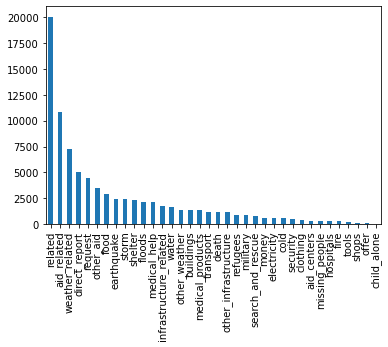

In [3]:
#lets see if the data is imbalanced
df.drop(columns=['message', 'original', 'genre', 'id']).sum().sort_values(ascending=False).plot.bar()

In [7]:
#plotting a list with the absolute value count
df.drop(columns=['message', 'original', 'genre', 'id']).sum().sort_values(ascending=False)

related                   20064
aid_related               10841
weather_related            7286
direct_report              5064
request                    4464
other_aid                  3441
food                       2917
earthquake                 2452
storm                      2440
shelter                    2308
floods                     2149
medical_help               2081
infrastructure_related     1705
water                      1669
other_weather              1376
buildings                  1331
medical_products           1311
transport                  1199
death                      1192
other_infrastructure       1151
refugees                    874
military                    859
search_and_rescue           724
money                       603
electricity                 532
cold                        528
security                    471
clothing                    404
aid_centers                 309
missing_people              298
hospitals                   283
fire    

In [8]:
#since the child_alone column are all 0, we can remove it as it doesn't 
#bring any information to the model and it prevents us from using the stratify
#option in the train_test_split
df.drop(columns=['child_alone'], inplace=True)

In [9]:
#the data is highly imbalanced, we will use the stratify parameter in the
#train_test_split to to ensure that relative class frequencies is approximately preserved

In [10]:
#checking for nulls
df.isnull().sum()

id                            0
message                       0
original                  16027
genre                         0
related                       0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops                         0
aid_centers                   0
other_infrastructure          0
weather_

In [11]:
#the original column have a very high number of null rows
#since the important column to us the the message column, we simply won't use it

### 2. Write a tokenization function to process your text data

In [12]:
def tokenize(text):    
    #clean
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    
    #tokenize
    tokens = word_tokenize(text)
    
    #stop words
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    
    #initiate lammatizer
    lemmatizer = WordNetLemmatizer()
    
    #loop through each token and record
    clean_tokens = []
    for token in tokens:
        lemmatize = lemmatizer.lemmatize(token.lower().strip())
        clean_tokens.append(lemmatize)
        
    return clean_tokens

In [13]:
tokenize(df['message'][3])

['un',
 'report',
 'leogane',
 '80',
 '90',
 'destroyed',
 'only',
 'hospital',
 'st',
 'croix',
 'functioning',
 'need',
 'supply',
 'desperately']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [14]:
#lets start trying with randomforest and multioutputclassifier for simplicity

pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfid', TfidfTransformer()),
    ('classifier', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [15]:
X = df['message']
y = df.drop(columns=['id', 'message', 'original', 'genre'])

#since we are dealing with a multilabel classification problem and we 
#want to split the data in a stratified manner, we will need to use the 
#IterativeStratification method from scikit-multilearn because
#the train_test_split with stratify doesn't support it
#I tried to use the iterative_train_test_split method but 
#apperently there is some problem with it's subsetting
#https://github.com/scikit-multilearn/scikit-multilearn/issues/199

stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[0.25, 0.75])
train_indexes, test_indexes = next(stratifier.split(X, y))
X_train, y_train = X.loc[train_indexes], y.loc[train_indexes]
X_test, y_test = X.loc[test_indexes], y.loc[test_indexes]

In [16]:
#lets confirm that the split was successful
print('X size: {}'.format(X.shape[0]))
print('X_train size: {}'.format(X_train.shape[0]))
print('X_test size: {}'.format(X_test.shape[0]))
print('y_train size: {}'.format(y_train.shape[0]))
print('y_test size: {}'.format(y_test.shape[0]))

df_proportion = pd.DataFrame({'y': y.sum() / y.shape[0],
                             'y_train': y_train.sum() / y_train.shape[0],
                             'y_test': y_test.sum() / y_test.shape[0]})
df_proportion['y-y_train'] = abs(df_proportion['y'] - df_proportion['y_train'])
df_proportion['y-y_test'] = abs(df_proportion['y'] - df_proportion['y_test'])
print('y-y_train proportions difference: {}'.format(df_proportion['y-y_train'].sum()))
print('y-y_test proportions difference: {}'.format(df_proportion['y-y_test'].sum()))
df_proportion

X size: 26180
X_train size: 19635
X_test size: 6545
y_train size: 19635
y_test size: 6545
y-y_train proportions difference: 0.17373312961548262
y-y_test proportions difference: 0.5211993888464477


,y,y_train,y_test,y-y_train,y-y_test
related,0.766387,0.766387,0.766387,0.000000,0.000000
request,0.170512,0.134810,0.277617,0.035702,0.107105
offer,0.004507,0.004380,0.004889,0.000127,0.000382
aid_related,0.414095,0.414107,0.414057,0.000013,0.000038
medical_help,0.079488,0.087701,0.054851,0.008212,0.024637
medical_products,0.050076,0.053680,0.039267,0.003603,0.010810
search_and_rescue,0.027655,0.028317,0.025668,0.000662,0.001986
security,0.017991,0.019048,0.014820,0.001057,0.003170
military,0.032811,0.041457,0.006875,0.008645,0.025936
water,0.063751,0.060810,0.072574,0.002941,0.008824


In [17]:
#lets compare this with the traditional train_test_split from sklearn
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, random_state=42)

In [18]:
#lets confirm that the split was successful
print('X size: {}'.format(X.shape[0]))
print('X2_train size: {}'.format(X2_train.shape[0]))
print('X2_test size: {}'.format(X2_test.shape[0]))
print('y2_train size: {}'.format(y2_train.shape[0]))
print('y2_test size: {}'.format(y2_test.shape[0]))

df_proportion2 = pd.DataFrame({'y': y.sum() / y.shape[0],
                             'y2_train': y2_train.sum() / y2_train.shape[0],
                             'y2_test': y2_test.sum() / y2_test.shape[0]})
df_proportion2['y-y2_train'] = abs(df_proportion2['y'] - df_proportion2['y2_train'])
df_proportion2['y-y2_test'] = abs(df_proportion2['y'] - df_proportion2['y2_test'])
print('y-y2_train proportions difference: {}'.format(df_proportion2['y-y2_train'].sum()))
print('y-y2_test proportions difference: {}'.format(df_proportion2['y-y2_test'].sum()))
df_proportion2

X size: 26180
X2_train size: 19635
X2_test size: 6545
y2_train size: 19635
y2_test size: 6545
y-y2_train proportions difference: 0.027845683728036617
y-y2_test proportions difference: 0.08353705118411012


,y,y2_train,y2_test,y-y2_train,y-y2_test
related,0.766387,0.768373,0.760428,0.001986,0.005959
request,0.170512,0.169595,0.173262,0.000917,0.002750
offer,0.004507,0.004380,0.004889,0.000127,0.000382
aid_related,0.414095,0.413598,0.415584,0.000497,0.001490
medical_help,0.079488,0.079450,0.079603,0.000038,0.000115
medical_products,0.050076,0.050929,0.047517,0.000853,0.002559
search_and_rescue,0.027655,0.027451,0.028266,0.000204,0.000611
security,0.017991,0.017214,0.020321,0.000777,0.002330
military,0.032811,0.031831,0.035752,0.000980,0.002941
water,0.063751,0.063509,0.064477,0.000242,0.000726


In [19]:
#The standard train_test_split actually give us better results
#so we will continue with it
X = df['message']
y = df.drop(columns=['id', 'message', 'original', 'genre'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
start = time.time()
#training the random forest pipeline
with parallel_backend('threading', n_jobs=8): #used to paralelize the fit
    pipeline.fit(X_train, y_train)
elapsed = time.time() - start
print(elapsed)

186.39155626296997


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [21]:
y_pred = pipeline.predict(X_test)

In [22]:
y_test

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
1968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17679,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1087,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7172,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6423,1,1,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
6919,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25651,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#testing the code for one model
df_test2 = pd.DataFrame()
report_test = classification_report(y_test.iloc[:,0], y_pred[:,0], output_dict=True)
df_test = pd.DataFrame(report_test).iloc[:3,3]
df_test = pd.concat([df_test2, df_test])
df_test.rename(columns={df_test.columns[0] : y_test.columns[0]})

,related
precision,0.777983
recall,0.677236
f1-score,0.703360


In [24]:
#since we have highly imbalanced data, we will go with the macro avg metric
#so each class have an equal weight
df_report = pd.DataFrame()
for i, v in enumerate(y_test):
    report = classification_report(y_test.iloc[:,i], y_pred[:,i], output_dict=True, zero_division=0)
    report = pd.DataFrame(report).iloc[:3,3]
    df_report = pd.concat([df_report, report], axis=1)
    df_report.rename(columns={df_report.columns[i] : y_test.columns[i]}, inplace=True)
df_report = df_report.transpose()
df_report

,precision,recall,f1-score
related,0.777983,0.677236,0.703360
request,0.874079,0.722980,0.768918
offer,0.497555,0.500000,0.498775
aid_related,0.779334,0.769322,0.772848
medical_help,0.844320,0.547616,0.567298
medical_products,0.834817,0.531513,0.547272
search_and_rescue,0.843377,0.513356,0.518986
security,0.489838,0.499922,0.494829
military,0.858218,0.531655,0.550330
water,0.938135,0.663712,0.730799


### 6. Improve your model
Use grid search to find better parameters. 

In [25]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000002B667AC3820>)),
  ('tfid', TfidfTransformer()),
  ('classifier', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000002B667AC3820>),
 'tfid': TfidfTransformer(),
 'classifier': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfid__norm': 'l2',
 'tfid__smooth_idf': True,
 'tfid__sublinear_tf'

In [26]:
#grid search with parallel processing, it took about 1 hour with 8 cores on a 9th gen i7 2.2Ghz with 8gb of ram
#start = time.time()
#with parallel_backend('threading', n_jobs=8):
#    parameters = {'classifier__estimator__min_samples_leaf': [1, 2],
#                  'classifier__estimator__min_samples_split': [2, 4],
#                  'classifier__estimator__n_estimators': [100, 200]}

#    cv = GridSearchCV(pipeline, parameters, scoring='f1_macro', cv=2)
#    cv.fit(X_train, y_train)

#elapsed = time.time() - start
#print(elapsed)

cv.cv_results_

{'mean_fit_time': array([ 746.83069479, 1296.14790618,  678.97463953, 1226.40756392,
         790.01018763,  887.13764822,  780.52179015,  976.72939503]),
 'std_fit_time': array([10.95283759,  9.67840469,  6.12980974, 14.17193437,  0.24451351,
         1.22423851,  2.32932508, 13.29320347]),
 'mean_score_time': array([901.86225879, 761.25261343, 862.6099515 , 727.66980684,
        791.49343503, 788.54778183, 640.35134363, 423.2940594 ]),
 'std_score_time': array([ 6.59378493,  2.49610007,  2.24478626, 10.42262018,  5.3449918 ,
         0.21644056,  0.44501972, 20.46273172]),
 'param_classifier__estimator__min_samples_leaf': masked_array(data=[1, 1, 1, 1, 2, 2, 2, 2],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__estimator__min_samples_split': masked_array(data=[2, 2, 4, 4, 2, 2, 4, 4],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__estimator__n_estimators': masked_array(data=[100, 200, 100, 200, 100, 200, 100, 200],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__estimator__min_samples_leaf': 1,
   'classifier__estimator__min_samples_split': 2,
   'classifier__estimator__n_estimators': 100},
  {'classifier__estimator__min_samples_leaf': 1,
   'classifier__estimator__min_samples_split': 2,
   'classifier__estimator__n_estimators': 200},
  {'classifier__estimator__min_samples_leaf': 1,
   'classifier__estimator__min_samples_split': 4,
   'classifier__estimator__n_estimators': 100},
  {'classifier__estimator__min_samples_leaf': 1,
   'classifier__estimator__min_samples_split': 4,
   'classifier__estimator__n_estimators': 200},
  {'classifier__estimator__min_samples_leaf': 2,
   'classifier__estimator__min_samples_split': 2,
   'classifier__estimator__n_estimators': 100},
  {'classifier__estimator__min_samples_leaf': 2,
   'classifier__estimator__min_samples_split': 2,
   'classifier__estimator__n_estimators': 200},
  {'classifier__estimator__min_samples_leaf': 2,
   'classifier__estimator__min_samples_split': 4,
   'classifier__estimator__n_estimators': 100},
  {'classifier__estimator__min_samples_leaf': 2,
   'classifier__estimator__min_samples_split': 4,
   'classifier__estimator__n_estimators': 200}],
 'split0_test_score': array([0.23702134, 0.24210713, 0.25160478, 0.24513717, 0.18048841,
        0.18010073, 0.1806209 , 0.17759464]),
 'split1_test_score': array([0.23550601, 0.2412008 , 0.24442992, 0.24573819, 0.1816217 ,
        0.1742592 , 0.17694008, 0.17921489]),
 'mean_test_score': array([0.23626368, 0.24165396, 0.24801735, 0.24543768, 0.18105506,
        0.17717996, 0.17878049, 0.17840477]),
 'std_test_score': array([0.00075766, 0.00045317, 0.00358743, 0.00030051, 0.00056665,
        0.00292076, 0.00184041, 0.00081012]),
 'rank_test_score': array([4, 3, 1, 2, 5, 8, 6, 7])}

In [27]:
#saving results into a csv so we don't need to run it again for the same parameters
#cv_rf_results = pd.DataFrame(cv.cv_results_)
#cv_rf_results.to_csv('Random_Forest_CV.csv')

In [28]:
#cv_rf_results

In [29]:
#Since the result were worse than the standard, we won't use them
#The best gridsearch result was test_score = 0.2516047759365685

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [30]:
df_report

,precision,recall,f1-score
related,0.777983,0.677236,0.703360
request,0.874079,0.722980,0.768918
offer,0.497555,0.500000,0.498775
aid_related,0.779334,0.769322,0.772848
medical_help,0.844320,0.547616,0.567298
medical_products,0.834817,0.531513,0.547272
search_and_rescue,0.843377,0.513356,0.518986
security,0.489838,0.499922,0.494829
military,0.858218,0.531655,0.550330
water,0.938135,0.663712,0.730799


In [39]:
print('precision average: {}'.format(df_report.iloc[:,0].mean()))
print('recall average: {}'.format(df_report.iloc[:,1].mean()))
print('f1-score average: {}'.format(df_report.iloc[:,2].mean()))

precision average: 0.7714042458513943
recall average: 0.5900876592148617
f1-score average: 0.6077821511864274


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [31]:
#lets try xgboost for comparison
#building the pipeline
pipeline_xgb = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfid', TfidfTransformer()),
    ('classifier', MultiOutputClassifier(XGBClassifier(use_label_encoder=False)))
])

In [32]:
#training the xgboost pipeline

start = time.time()
with parallel_backend('threading', n_jobs=8): #used to paralelize the fit
    pipeline_xgb.fit(X_train, y_train)
elapsed = time.time() - start
print(elapsed)

121.62641191482544


In [43]:
y_pred_xgb = pipeline_xgb.predict(X_test)

In [44]:
df_report_xgb = pd.DataFrame()
for i, v in enumerate(y_test):
    report = classification_report(y_test.iloc[:,i], y_pred_xgb[:,i], output_dict=True, zero_division=0)
    report = pd.DataFrame(report).iloc[:3,3]
    df_report_xgb = pd.concat([df_report_xgb, report], axis=1)
    df_report_xgb.rename(columns={df_report_xgb.columns[i] : y_test.columns[i]}, inplace=True)
df_report_xgb = df_report_xgb.transpose()
df_report_xgb

,precision,recall,f1-score
related,0.775341,0.559141,0.548411
request,0.859110,0.713124,0.757028
offer,0.497555,0.500000,0.498775
aid_related,0.760410,0.720694,0.726119
medical_help,0.773823,0.582601,0.616420
medical_products,0.848273,0.629427,0.683630
search_and_rescue,0.730413,0.547155,0.573854
security,0.739986,0.507363,0.509465
military,0.836735,0.613562,0.665691
water,0.899579,0.811696,0.849322


In [45]:
print('precision average: {}'.format(df_report_xgb.iloc[:,0].mean()))
print('recall average: {}'.format(df_report_xgb.iloc[:,1].mean()))
print('f1-score average: {}'.format(df_report_xgb.iloc[:,2].mean()))

precision average: 0.7945655381287086
recall average: 0.6373720398829625
f1-score average: 0.6669273379009469


In [46]:
pipeline_xgb.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000002B667AC3820>)),
  ('tfid', TfidfTransformer()),
  ('classifier',
   MultiOutputClassifier(estimator=XGBClassifier(use_label_encoder=False)))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000002B667AC3820>),
 'tfid': TfidfTransformer(),
 'classifier': MultiOutputClassifier(estimator=XGBClassifier(use_label_encoder=False)),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfid__norm': 'l2',
 'tfid__smooth_id

In [47]:
#the xgb gave us better results in a shorter fitting time
#lets try to gridsearch it

# start = time.time()
# with parallel_backend('threading', n_jobs=8):
#     parameters = {'classifier__estimator__min_samples_leaf': [1, 2],
#                  'classifier__estimator__min_samples_split': [2, 4],
#                  'classifier__estimator__n_estimators': [100, 200]}

#     cv = GridSearchCV(pipeline, parameters, scoring='f1_macro', cv=2)
#     cv.fit(X_train, y_train)

# elapsed = time.time() - start
# print(elapsed)

#saving results into a csv so we don't need to run it again for the same parameters
# cv_xgb_results = pd.DataFrame(cv.cv_results_)
# cv_xgb_results.to_csv('XGBoost_CV.csv')

# cv_xgb_results

#Since the result were worse than the standard, we won't use them
#The best gridsearch result was test_score = 0.245158

3515.9582340717316


NameError: name 'cv_rf_results' is not defined

### 9. Export your model as a pickle file

In [49]:
pkl_filename = "xgboost.pkl"  

with open(pkl_filename, 'wb') as file:  
    pickle.dump(pipeline_xgb, file)

In [50]:
#testing to load the pickle file
with open(pkl_filename, 'rb') as file:  
    test_pipeline = pickle.load(file)

test_pipeline
#it works as intended

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000002B667AC3820>)),
                ('tfid', TfidfTransformer()),
                ('classifier',
                 MultiOutputClassifier(estimator=XGBClassifier(missing=nan,
                                                               use_label_encoder=False)))])

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.